In [2]:
import pandas as pd

In [3]:
df1 = pd.read_csv(r'C:\Users\mupsi\Desktop\crowdsourced_curl\full_dataset_21jun.csv', dtype='string')

In [9]:
import wordcloud
from wordcloud import WordCloud
from wordcloud import STOPWORDS

In [6]:
alltext = ','.join(list(df1['lemmatized_txt'].values))

In [47]:
full_text = ','.join(list(df1['Text'].values))

In [303]:
cloud_stop_words = ['curl','curls','curly','good','leave','want','thing', 'x200b','doesn','advice','head','going','hair', 'product', '2b','2c','3a','3b','3c','4a','4b','4c','lot','seem','really','aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn']+list(STOPWORDS)
#
#wordcloud = WordCloud(background_color="black", contour_color='steelblue', stopwords = cloud_stop_words)

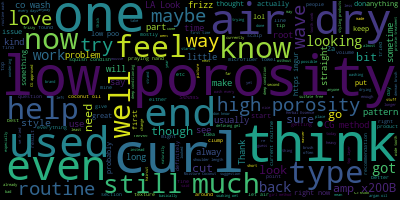

In [56]:
wordcloud.generate(full_text)
wordcloud.to_image()

#### potential topics: porosity, dryness, frizz, co-wash, 

In [57]:
import numpy as np

In [62]:
full_text_unique = np.unique(full_text)
full_text_str = np.array2string(full_text_unique)

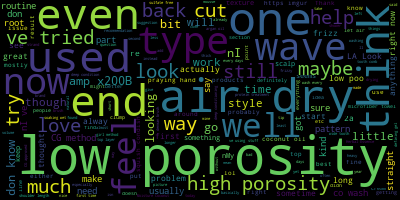

In [67]:
wordcloud.generate(full_text_str)
wordcloud.to_image()

# BEGIN TOPIC MODELING WITH SCIKITLEARN

In [69]:
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

import matplotlib.pyplot as plt

In [72]:
vectorizer = CountVectorizer(analyzer='word', min_df=10, stop_words = cloud_stop_words, strip_accents = 'unicode', ngram_range=(1,3), max_features=2500)

In [323]:
vectorized_txt = vectorizer.fit_transform(df1['lemmatized_txt'])

In [324]:
data_dense = vectorized_txt.todense()

In [325]:
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  1.3872747520265194 %


In [81]:
lda_model = LatentDirichletAllocation(n_components=5, random_state=100)

lda_output = lda_model.fit_transform(vectorized_txt)

print(lda_model)

In [ ]:
# high log likelihood & low perplexity = GOOD

In [85]:
print("Log Likelihood: ", lda_model.score(vectorized_txt))

Log Likelihood:  -11197898.335395103


In [87]:
print("Perplexity: ", lda_model.perplexity(vectorized_txt))

Perplexity:  1049.8339389198225


In [88]:
print(lda_model.get_params())

{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 5, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 100, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [255]:
lda_model_10 = LatentDirichletAllocation(n_components=10, learning_decay=0.5, random_state=100)

In [258]:
lda_output_10 = lda_model_10.fit_transform(vectorized_txt)

In [259]:
print(lda_model_10)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.5,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [261]:
print("Log Likelihood: ", lda_model_10.score(vectorized_txt))

Log Likelihood:  -11114701.648560416


In [263]:
print("Perplexity: ", lda_model_10.perplexity(vectorized_txt))

Perplexity:  996.9529895252683


In [288]:
-11114701 + 996

-11113705

In [ ]:
topics = ['Topic' + str(i) for i in range(lda_model_10.n_components)]

In [110]:
postnames = ["Post" + str(i) for i in range(len(df1))]

In [121]:
df_topics = pd.DataFrame(np.round(lda_output, 2), columns=topics, index = postnames) 

In [122]:
dominant_topic = np.argmax(df_topics.values, axis=1)

In [123]:
df_topics['dominant_topic'] = dominant_topic

In [125]:
# Styling
def color_green(val):
    color = 'red' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_topics_table = df_topics.head(15).style.applymap(color_green).applymap(make_bold)
df_topics_table

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Post0,0.050000,0.050000,0.550000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,2
Post1,0.380000,0.010000,0.010000,0.580000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,3
Post2,0.120000,0.000000,0.000000,0.270000,0.000000,0.060000,0.000000,0.000000,0.540000,0.000000,8
Post3,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.470000,0.000000,0
Post4,0.440000,0.030000,0.120000,0.070000,0.000000,0.170000,0.060000,0.030000,0.070000,0.000000,0
Post5,0.070000,0.460000,0.210000,0.000000,0.000000,0.000000,0.220000,0.000000,0.000000,0.030000,1
Post6,0.300000,0.000000,0.000000,0.000000,0.300000,0.280000,0.000000,0.000000,0.110000,0.000000,0
Post7,0.500000,0.000000,0.000000,0.000000,0.200000,0.280000,0.000000,0.000000,0.000000,0.000000,0
Post8,0.010000,0.010000,0.010000,0.010000,0.300000,0.270000,0.010000,0.010000,0.390000,0.010000,8
Post9,0.400000,0.000000,0.180000,0.000000,0.220000,0.000000,0.000000,0.000000,0.190000,0.000000,0


In [126]:
df_topic_distribution = df_topics['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,4,6863
1,3,5529
2,0,5226
3,2,4989
4,5,4770
5,9,3439
6,7,2663
7,1,2559
8,8,1857
9,6,718


In [128]:
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt

In [147]:
pyLDAvis.enable_notebook
panel = pyLDAvis.sklearn.prepare(lda_model, vectorized_txt, vectorizer = vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2      32.420952   8.115230       1        1  18.510169
5       0.648955  71.707100       2        1  14.381488
0      71.019684   9.971006       3        1  13.160347
3       3.785981  33.185135       4        1  11.470793
4     -42.666500  -9.222070       5        1  10.083343
9      -3.621689 -43.526516       6        1   7.479033
1      -3.632402  -4.171708       7        1   7.415148
7     -36.584400  35.804413       8        1   7.256646
8      44.391380  50.615383       9        1   6.565624
6      40.235809 -31.591665      10        1   3.677409, topic_info=          Term          Freq         Total Category  logprob  loglift
1497       oil   9532.000000   9532.000000  Default  30.0000  30.0000
1626  porosity  11188.000000  11188.000000  Default  29.0000  29.0000
568   devacurl   5348.000000   5348.000000  Default  28.0000  28.0000
872  

In [139]:
# get topic keywords
df_topic_keywords = pd.DataFrame(lda_model.components_)
df_topic_keywords.columns=vectorizer.get_feature_names()
df_topic_keywords.index = topics

In [140]:
df_topic_keywords.head()

,10,10 15,10 min,10 minute,10 year,100,11,12,13,14,...,yes,yesterday,yogurt,young,younger,youtu,youtube,youtube video,youtube watch,zero
Topic0,42.221303,0.100011,0.100016,0.111776,0.100014,21.993886,7.207014,36.352297,0.142082,1.667756,...,32.781449,106.209061,0.100007,8.014349,11.741197,6.257804,189.532837,31.991206,115.848458,28.184555
Topic1,31.740253,0.100009,0.100009,0.101530,4.189956,45.735627,0.497413,18.484064,15.268666,5.215431,...,0.159076,36.147191,0.100011,0.100007,0.100018,0.100011,2.280896,0.100065,0.100010,1.465541
Topic2,1183.730802,211.099918,202.465584,450.015415,3.230812,189.002735,24.396331,56.060610,7.506193,7.359527,...,9.378904,128.259504,12.901469,0.453211,0.100010,7.048750,13.658742,0.310653,0.100012,13.248499
Topic3,198.886130,0.100006,0.100008,0.100011,102.023120,92.484340,59.800014,47.218898,54.024041,37.501263,...,161.648714,70.740156,0.100013,112.764374,99.520313,97.816898,618.004492,177.997998,0.100100,12.508556
Topic4,0.528499,0.100007,0.100006,0.100007,0.100007,41.246778,0.100013,0.100014,0.100221,0.100020,...,341.802680,23.456829,0.100007,0.100018,10.883529,14.061867,83.519176,0.100024,0.100028,32.998874


In [143]:
# Show top n keywords for each topic
def show_topics_10(vectorizer=vectorizer, lda_model=lda_model_10, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,dry,wash,use,time,look,brush,method,frizzy,scalp,shower,wet,feel,tried,washing,air
Topic 1,devacurl,gel,use,cream,deva,poo,defining,styling,cantu,recommendation,defining gel,looking,ultra,x200b,condition
Topic 2,gel,dry,scrunch,water,air,plop,wet,wash,hand,air dry,minute,apply,squish,diffuse,use
Topic 3,people,started,cgm,method,time,straight,girl,year,care,new,post,look,month,natural,thought
Topic 4,wave,look,gel,pattern,straight,different,doesn,way,say,fine,ringlet,hold,bit,right,frizz
Topic 5,moisture,protein,use,gel,coconut,deep,oil,porosity,wash,treatment,cream,tried,free,heavy,mousse
Topic 6,comb,brush,wide,use,tooth,shower,wide tooth,tooth comb,wide tooth comb,jpg,finger,wet,detangle,tangle,dry
Topic 7,look,heat,year,time,month,damage,color,natural,damaged,treatment,ago,frizzy,straight,dry,dye
Topic 8,oil,porosity,high,high porosity,medium,density,fine,coconut,use,water,moisture,scalp,ingredient,castor,tree
Topic 9,length,layer,long,shoulder,look,short,style,haircut,stylist,shoulder length,time,bang,end,got,shorter


In [ ]:
# washing/drying: topic 0, 2
# curl definition: topic 1, 4
# curlygirl method: topic 3
# growing your hair out/lengths: topic 9, 
# dryness/moisture: topic 5
# detangling: topic 6
# heat/color damage: topic 7
# moisture/porosity: topic 8

# models to explore the grid

https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

In [368]:
#### This takes forever on your machine - figure this out later - just do a little model searching on your own 
#Do a gridsearch to find the best model

search_params = {'n_components': [5,8,10,11], 'learning_decay':[.5, .7, .9],  'random_state':[100]}

lda = LatentDirichletAllocation()
model = GridSearchCV(lda, param_grid = search_params)

model.fit(vectorized_txt)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [370]:
best_lda_model = model.best_estimator_

In [374]:
model.best_estimator_

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.5,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=8, n_jobs=None,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [371]:
best_lda_model

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.5,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=8, n_jobs=None,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [372]:
model.best_params_

{'learning_decay': 0.5, 'n_components': 8, 'random_state': 100}

In [377]:
show_topics(vectorizer, best_lda_model, n_words=20)

[array(['dry', 'wash', 'length', 'time', 'look', 'use', 'long', 'shoulder',
        'end', 'method', 'morning', 'frizzy', 'night', 'scalp', 'usually',
        'feel', 'washing', 'shower', 'hour', 'sleep'], dtype='<U27'),
 array(['devacurl', 'deva', 'gel', 'use', 'cream', 'poo', 'defining',
        'recommendation', 'styling', 'looking', 'defining gel', 'x200b',
        'tried', 'new', 'ultra', 'dry', 'thanks', 'time', 'imgur', 'cantu'],
       dtype='<U27'),
 array(['gel', 'dry', 'scrunch', 'water', 'air', 'wash', 'plop', 'wet',
        'air dry', 'hand', 'minute', 'apply', 'squish', 'use', 'diffuse',
        'rinse', 'shower', 'look', 'upside', 'moisture'], dtype='<U27'),
 array(['porosity', 'people', 'high', 'girl', 'method', 'say', 'cgm',
        'post', 'care', 'different', 'new', 'look', 'type', 'reddit',
        'high porosity', 'comment', 'medium', 'video', 'thank', 'density'],
       dtype='<U27'),
 array(['wave', 'look', 'gel', 'pattern', 'straight', 'layer', 'hold',
        '

In [252]:
lda_model_5topics = LatentDirichletAllocation(n_components=5, random_state=100)

lda_output_5topics = lda_model_5topics.fit_transform(vectorized_txt)

print(lda_model)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.5,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [254]:
print("Log Likelihood: ", lda_model_5topics.score(vectorized_txt))
print("Perplexity: ", lda_model_5topics.perplexity(vectorized_txt))

Log Likelihood:  -11197898.335395103
Perplexity:  1049.8339389198225


In [289]:
-11197898 - 1049

-11198947

In [264]:
topics = ['Topic' + str(i) for i in range(lda_model_5topics.n_components)]
postnames = ["Post" + str(i) for i in range(len(df1))]

In [265]:
df_5topics = pd.DataFrame(np.round(lda_output_5topics, 2), columns=topics, index = postnames) 

In [266]:
dominant_5topics = np.argmax(df_topics.values, axis=1)
df_5topics['dominant_5topics'] = dominant_5topics

In [267]:
# Show top n keywords for each topic
def show_topics_5(vectorizer=vectorizer, lda_model=lda_model_5topics, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model_5topics, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,look,dry,time,wash,length,straight,long,brush,end,use,frizzy,wet,wave,way,method
Topic 1,use,oil,devacurl,wash,moisture,dry,scalp,free,cream,time,month,coconut,deva,tried,sulfate
Topic 2,gel,dry,use,scrunch,wash,moisture,water,wet,air,plop,coconut,porosity,oil,air dry,hand
Topic 3,porosity,high,people,high porosity,medium,natural,care,year,black,started,girl,density,post,say,method
Topic 4,gel,wave,protein,look,fine,porosity,use,pattern,hold,doesn,straight,different,heavy,say,frizz


In [271]:
# test 12 topics

lda_model_12 = LatentDirichletAllocation(n_components=12, random_state=100)

lda_output_12 = lda_model_12.fit_transform(vectorized_txt)

print(lda_model_12)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=12, n_jobs=None,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [272]:
print("Log Likelihood: ", lda_model_12.score(vectorized_txt))
print("Perplexity: ", lda_model_12.perplexity(vectorized_txt))

Log Likelihood:  -11100735.021946544
Perplexity:  988.3404595966464


In [291]:
-11100735+988

-11099747

In [282]:
t12topics = ['Topic' + str(i) for i in range(lda_model_12.n_components)]
df_12topics = pd.DataFrame(np.round(lda_output_12, 2), columns=t12topics, index = postnames)
dominant_12topics = np.argmax(df_12topics.values, axis=1)
df_12topics['dominant_12topics'] = dominant_12topics

In [286]:
def show_topics_12(vectorizer=vectorizer, lda_model=lda_model_12, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model_12, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,wash,dry,use,scalp,time,brush,shower,washing,method,look,feel,wet,frizzy,greasy,usually
Topic 1,devacurl,gel,cream,use,deva,poo,defining,cantu,styling,defining gel,ultra,looking,condition,recommendation,moisture
Topic 2,dry,scrunch,gel,water,air,plop,wash,hand,air dry,wet,apply,squish,minute,diffuse,use
Topic 3,started,year,cgm,method,month,time,straight,ago,new,girl,natural,care,got,thanks,trying
Topic 4,gel,wave,look,hold,frizz,use,fine,mousse,tried,way,doesn,straight,better,definition,clump
Topic 5,moisture,protein,use,coconut,deep,gel,porosity,oil,treatment,wash,hibiscus,kinky,mask,line,heavy
Topic 6,comb,brush,wide,shower,use,tooth,wide tooth,tooth comb,wide tooth comb,jpg,finger,wet,detangle,tangle,dry
Topic 7,heat,look,damage,time,color,dry,damaged,treatment,frizzy,year,feel,end,use,dye,month
Topic 8,oil,porosity,high,high porosity,medium,fine,density,use,coconut,water,ingredient,moisture,argan,coconut oil,tree
Topic 9,length,layer,shoulder,long,look,short,style,haircut,shoulder length,bang,stylist,time,end,shorter,longer


# tried this with stopwords but this does NOT improve things, better to go back to original list

In [318]:
# go through and add common words to stopwords before you run it again
cloud_stop_words = ['curl','curls','curly','good','leave','want','thing', 'x200b','doesn','advice','head','going','hair', 'product', '2b','2c','3a','3b','3c','4a','4b','4c','lot','seem','really','aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn']+list(STOPWORDS)

#cloud_stop_words = ['shea','curl','curls','curly','good','leave','want','thing','advice','head','going','day', 'hair', 'product', '2b','2c','3a','3b','3c','4a','4b','4c','shampoo','conditioner','wavy','lot','seem','really','aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', \
#                     'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn','wash','use', 'reddit', 'ago','got','post','doesn'\
#                    'usually','look','say', 'x200b']+list(STOPWORDS)
# 

In [319]:
# try again with additional stopwords
vectorizer2 = CountVectorizer(analyzer='word', min_df=20, stop_words = cloud_stop_words, strip_accents = 'unicode', ngram_range=(1,3), max_features=2500)
vectorized_txt2 = vectorizer2.fit_transform(df1['lemmatized_txt'])
data_dense2 = vectorized_txt2.todense()
print("Sparsicity: ", ((data_dense2 > 0).sum()/data_dense2.size)*100, "%")

Sparsicity:  1.433792764094994 %


In [320]:
# rerun model w/ 8 TOPICS

# test 8 topics again
lda_model_8 = LatentDirichletAllocation(n_components=8, random_state=100)
lda_output_8 = lda_model_8.fit_transform(vectorized_txt2)
print("Log Likelihood: ", lda_model_8.score(vectorized_txt2))
print("Perplexity: ", lda_model_8.perplexity(vectorized_txt2))

Log Likelihood:  -11517305.712051012
Perplexity:  939.0917656606716


In [321]:
t8topics = ['Topic' + str(i) for i in range(lda_model_8.n_components)]
df_8topics = pd.DataFrame(np.round(lda_output_8, 2), columns=t8topics, index = postnames)
dominant_8topics = np.argmax(df_8topics.values, axis=1)
df_8topics['dominant_8topics'] = dominant_8topics

In [322]:
# Show top n keywords for each topic
def show_topics_8(vectorizer=vectorizer, lda_model=lda_model_8, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model_8, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,sea,conditioned,use coconut,denman brush,wash moisture,np reddit message,ruin,dryer,suit,frizzier,silk,seal,fine dense,coat,watching
Topic 1,gel praying hand,dirty,use coconut,honey,direct,curlsmith,loc method,plop,tried plopping,devacurl light,kinky curling,moisturizing,la look blue,fusion,styler gel
Topic 2,dryer,denman brush,time dry,started,air,game changer,moisture protein,tried plopping,loc method,wet use,mell,year,wash moisture,lmao,air dry
Topic 3,dryer,safe,gel praying hand,conditioned,wash moisture,air dry,pillow,water shirt,denman brush,air dry rest,wet use,sea,squish condish,hard tell,microfibre towel
Topic 4,plopped,finishing,history,use coconut,hold,match,gel praying hand,didn,loc method,wavier,mell,wet use,water shirt,worked,week
Topic 5,miracle,serum,setting,conditioned,coat,sea,use coconut,gel praying hand,curlsmith,camille rose,plopped,high school,bun,soak,coconut curling cream
Topic 6,loc method,straight,weather,wavier,time dry,let,layered,lmao,parabens,page,row,morning,denman brush,week,growing
Topic 7,price,detangler,conditioned,miracle,tree,np reddit message,brown,use coconut,determine,manageable,serum,country,concerned,wash moisture,setting


In [ ]:
# Topic 0 - morning/nighttime routines
# Topic 1 - devacurl 
# Topic 2 - Drying methods (air, plopping, diffuser)
# Topic 3 - Curlygirl method
# Topic 4 - Wavy/Frizzy hair
# Topic 5 - Moisture, deep treatment, coconut
# Topic 6 - Brushing and combing
# Topic 7 - Heat damage/Growing advice

# this is the winner

In [326]:
# test 8 topics

lda_model_8 = LatentDirichletAllocation(n_components=8, random_state=100)

lda_output_8 = lda_model_8.fit_transform(vectorized_txt)

print(lda_model_8)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=8, n_jobs=None,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [327]:
print("Log Likelihood: ", lda_model_8.score(vectorized_txt))
print("Perplexity: ", lda_model_8.perplexity(vectorized_txt))

Log Likelihood:  -11129213.074249227
Perplexity:  1005.980978272558


In [290]:
-11129213+1005

-11128208

In [328]:
t8topics = ['Topic' + str(i) for i in range(lda_model_8.n_components)]
df_8topics = pd.DataFrame(np.round(lda_output_8, 2), columns=t8topics, index = postnames)
dominant_8topics = np.argmax(df_8topics.values, axis=1)
df_8topics['dominant_8topics'] = dominant_8topics

In [329]:
# Show top n keywords for each topic
def show_topics_8(vectorizer=vectorizer, lda_model=lda_model_8, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model_8, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,dry,wash,length,time,look,use,long,shoulder,end,method,morning,frizzy,night,scalp,usually
Topic 1,devacurl,deva,gel,use,cream,poo,defining,recommendation,styling,looking,defining gel,x200b,tried,new,ultra
Topic 2,gel,dry,scrunch,water,air,wash,plop,wet,air dry,hand,minute,apply,squish,use,diffuse
Topic 3,porosity,people,high,girl,method,say,cgm,post,care,different,new,look,type,reddit,high porosity
Topic 4,wave,look,gel,pattern,straight,layer,hold,fine,use,way,doesn,different,frizz,ringlet,bit
Topic 5,oil,moisture,use,protein,porosity,gel,coconut,deep,wash,cream,fine,treatment,high,water,tried
Topic 6,brush,comb,use,shower,wide,dry,scalp,sulfate,silicone,wet,free,frizz,tooth,wide tooth,tooth comb
Topic 7,look,straight,year,time,month,heat,ago,started,natural,got,long,feel,damage,frizzy,wave


In [ ]:
# Topic 0 - morning/nighttime routines
# Topic 1 - devacurl 
# Topic 2 - Drying methods (air, plopping, diffuser)
# Topic 3 - Curlygirl method
# Topic 4 - Wavy/Frizzy hair
# Topic 5 - Moisture, deep treatment, coconut
# Topic 6 - Brushing and combing
# Topic 7 - Heat damage/Growing advice

In [332]:
# ok now predict on texts:
topic_values = lda_model_8.transform(vectorized_txt)

In [352]:
topic_values.shape

(38613, 8)

In [355]:
topic_values[1]

array([0.0069536 , 0.00695277, 0.00694712, 0.65200762, 0.00695026,
       0.30628758, 0.00694944, 0.0069516 ])

In [356]:
top_topics = np.argpartition(topic_values, -3, axis=1)[]

In [358]:
top_topics[1]

array([6, 7, 2, 1, 4, 0, 5, 3], dtype=int64)

In [360]:
topic_values[2]

array([0.0023172 , 0.00231802, 0.00231592, 0.4050843 , 0.00231687,
       0.52193002, 0.06140136, 0.00231632])

In [359]:
top_topics[2]

array([4, 7, 2, 0, 1, 6, 3, 5], dtype=int64)

In [354]:
top_topics.shape

(38613, 8)

In [363]:
top_topics = np.argpartition(topic_values, -4)[:-4]

In [364]:
top_topics

array([[4, 3, 7, ..., 1, 2, 5],
       [2, 6, 4, ..., 0, 5, 3],
       [4, 7, 2, ..., 6, 3, 5],
       ...,
       [1, 5, 6, ..., 4, 0, 3],
       [5, 0, 2, ..., 4, 6, 7],
       [2, 5, 4, ..., 0, 3, 7]], dtype=int64)

In [366]:
# maybe gotta write a loop to loop thru each array w/in the array (???) to get out top 3
# THIS DID NOT WORK - LAST THING TO DO BEFORE MOVING ON TO STREAMLITTTT
for x in topic_values:
    top_topics = []
    top = np.argpartition(topic_values, -4, axis=1)
    top_topics.append(top)

In [367]:
top_topics

[array([[4, 3, 7, ..., 1, 2, 5],
        [2, 6, 4, ..., 0, 5, 3],
        [4, 7, 2, ..., 6, 3, 5],
        ...,
        [2, 6, 5, ..., 0, 7, 3],
        [5, 7, 6, ..., 4, 2, 3],
        [0, 5, 2, ..., 4, 7, 3]], dtype=int64)]

In [346]:
df1['Topic'] = topic_values.argmax(axis=1)

ValueError: Wrong number of items passed 8, placement implies 1

In [335]:
df1.head()

,Unnamed: 0,author,id,Link,created_utc,Text,parent_id,Hairtype,num_comments,num_crossposts,selftext,title,lemmatized_txt,Topic
0,0,author,id,permalink,created_utc,text_body,parent_id,hairtype,num_comments,num_crossposts,selftext,title,tresemme,2
1,1,fairyfiffin,e0e2zaz,/r/curlyhair/comments/8pjwgr/help_devacurl_alt...,1528565510,I haven't stumbled upon the loc/lco method tha...,t1_e0che3v,Dreadlocks,,,,,haven t stumbled loc lco method thanks bringin...,3
2,2,catgirl1359,e0g7f31,/r/curlyhair/comments/8q3nsi/curly_trouble/e0g...,1528663660,"To me, you look like a 3c but it's much more i...",t3_8q3nsi,Dreadlocks,,,,,look like s important porosity http www ouidad...,5
3,3,caramel_drop,e0g890t,/r/curlyhair/comments/8q3nsi/curly_trouble/e0g...,1528664498,"Thanks! So, I kknow about the LOC/LCO but I am...",t1_e0g7f31,Dreadlocks,,,,,thanks kknow loc lco suppose follow doing poro...,5
4,4,bonghits4jess,e0qot0b,/r/curlyhair/comments/8r1qlk/the_weekly_no_que...,1529098718,I'm struggling with my hair so hard lately! B...,t3_8r1qlk,Dreadlocks,,,,,m struggling hair hard lately background went ...,5
